# Compare Average Bubbles

In [1]:
import numpy as np
from numpy import load
import math
import matplotlib
import matplotlib.pyplot as plt
import scipy as scp
import scipy.optimize as sco
import scipy.signal as scs
import scipy.special as ssp
from itertools import zip_longest, compress, count, islice, groupby, cycle, chain
import os
import scipy.ndimage as ndi
from scipy.ndimage import gaussian_filter1d, gaussian_filter

In [2]:
np_load_old = np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

### Simulation Parameters 

In [33]:
nLat = 4096
nu = 2.*10**(-3)
lenLat = 2 * 50. / np.sqrt(2. * nu)
nyq = nLat//2+1
spec = nyq
hLat = nLat//2
dx = lenLat/nLat
dk = 2.*np.pi/lenLat

# units
alpha = 8.
dk = 2.*np.pi/lenLat
dt = dx/alpha
dtout = dt*alpha

def source(ss):
    if ss == 'thin':
        # thin wall
        nSims = 390
        lamb = 6
        m2eff = 4. * nu * (- 1. + lamb**2)
        phi0 = 2. * np.pi / 7.
        instanton_location = '/home/dpirvu/inst/instantons/dev/thin_wall_instanton_sim.dat'
        sim_location = lambda sim: '/gpfs/dpirvu/sims/x'+str(nLat)+'_phi0{:.4f}'.format(phi0)+'_lambda{:.4f}'.format(lamb)+'_sim'+str(sim)+'_fields.dat'
        coleman_profile = np.pi+np.genfromtxt(instanton_location)[:,0] # theoretical bubble profile
        pickle_location = '/home/dpirvu/pickle_location/thin_wall_average_bubble/old_'
        cutout_location = '/gpfs/dpirvu/thin_wall_average_bubble/'
        suffix = '_for_phi0{:.4f}'.format(phi0)+'_len{:.4f}'.format(lenLat)+'_lamb{:.4f}'.format(lamb)+'_x'+str(nLat)
    elif ss == 'thick':
        # thick wall
        nSims = 100
        lamb = 1.5
        m2eff = 4. * nu * (- 1. + lamb**2)
        phi0 = 2. * np.pi / 4.
        instanton_location = '/home/dpirvu/inst/instantons/dev/thick_wall_instanton_sim.dat'
        sim_location = lambda sim: '/gpfs/dpirvu/sims/x'+str(nLat)+'_phi0{:.4f}'.format(phi0)+'_lambda{:.4f}'.format(lamb)+'_sim'+str(sim)+'_fields.dat'
        coleman_profile = np.pi+np.genfromtxt(instanton_location)[:,0] # theoretical bubble profile
        pickle_location = '/home/dpirvu/pickle_location/thick_wall_average_bubble/'
        cutout_location = '/gpfs/dpirvu/thick_wall_average_bubble/'
        suffix = '_for_phi0{:.4f}'.format(phi0)+'_lambda'+str(lamb)+'_len{:.4f}'.format(lenLat)+'_x'+str(nLat)
    return nSims, lamb, m2eff, phi0, instanton_location, sim_location, coleman_profile, pickle_location, cutout_location, suffix

titles = [r'$\phi(x)$', r'$\partial_t \phi(x)$', r'$|\nabla \phi(x)|^2$', r'$V(\phi(x))$']
plots_file = '/home/dpirvu/average_bubble/oscillon/plots/'
bubbles_file = lambda sim, phi0, lamb, lenLat, nLat: '/gpfs/dpirvu/oscillons/bubble_sim'+str(sim)+'_for_phi0{:.4f}'.format(phi0)+'_lambda{:.4f}'.format(lamb)+'_len{:.4f}'.format(lenLat)+'_x'+str(nLat)+'.npy'
V = lambda x, lamb : (-np.cos(x)+0.5*lamb**2.*np.sin(x)**2.)*4.*nu
right_phi_at_V_max = lambda lamb: sco.minimize_scalar(lambda x: -V(x, lamb), bounds=[np.pi, 2*np.pi], method='bounded')
left_phi_at_V_max = lambda lamb: sco.minimize_scalar(lambda x: -V(x, lamb), bounds=[0, np.pi], method='bounded')

def time_at_fraction(bubble, frac, limit):
    T, N = len(bubble), len(bubble[0])
    for ttt, slice in enumerate(bubble[::-1]):
        right_phi_x = len(slice[slice>=limit])
        if right_phi_x <= N*frac:
            return T-ttt

def time_at_max_fraction(simulation, limit):
    bubble = np.transpose(simulation)
#    SC = ndi.morphology.binary_opening(simulation > limit, iterations=5, structure=np.ones((3,3)))
#    bubble[~SC] = 0
    maxx, maxm = 0., 0.
    for xxx, slice in enumerate(bubble):
        right_phi_x = len(slice[(slice>=limit)&(slice<3*np.pi)])
        if maxm < right_phi_x:
            maxm = right_phi_x
            maxx = xxx
    return maxx, maxm*simulation.shape[0]/simulation.shape[1]**2.

<ipython-input-4-ca7d3c2e1554>:6: PeakPropertyWarning: some peaks have a width of 0
  fwhm, height, left_ips, right_ips = scs.peak_widths(temp, peaks, rel_height=0.5)


filter_size =  173.7779557760698 0.3860202221885229
filter_size =  50.64720254541112 0.3860202221885229


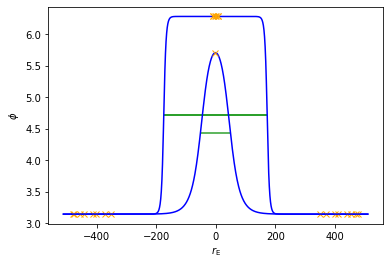

In [4]:
for test in ['thin', 'thick']: 
    nSims, lamb, m2eff, phi0, instanton_location, sim_location, coleman_profile, pickle_location, cutout_location, suffix = source(test)
    xoffset = nLat//8
    temp = coleman_profile[len(coleman_profile)//2-xoffset:len(coleman_profile)//2+xoffset]
    peaks, _ = scs.find_peaks(temp)
    fwhm, height, left_ips, right_ips = scs.peak_widths(temp, peaks, rel_height=0.5)
    filter_size = max(fwhm)/2.; print('filter_size = ', filter_size, dx)
    radius_Coleman_bubble = filter_size*dx

    plt.plot(np.arange(len(temp))-xoffset, temp, color='b')
    plt.plot(peaks-xoffset, temp[peaks], "x", color='orange')
    [plt.hlines(height[i], left_ips[i]-xoffset, right_ips[i]-xoffset, color="C2") for i in range(len(fwhm))]
    plt.xlabel(r'$r_{\rm E}$'); plt.ylabel(r'$\phi$')

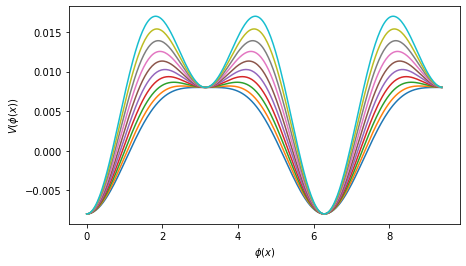

In [5]:
fig = plt.figure(figsize=(7, 4))
plt.xlabel(r'$\phi(x)$'); plt.ylabel(r'$V(\phi(x))$')
for lm in np.linspace(1, 2, 10):
    plt.plot([i for i in np.arange(0, 3*np.pi, np.pi/100)], [V(i, lm) for i in np.arange(0, 3*np.pi, np.pi/100)])

### Average Oscillon Signal from all Deboosted Thin Wall Bubble Precursors 

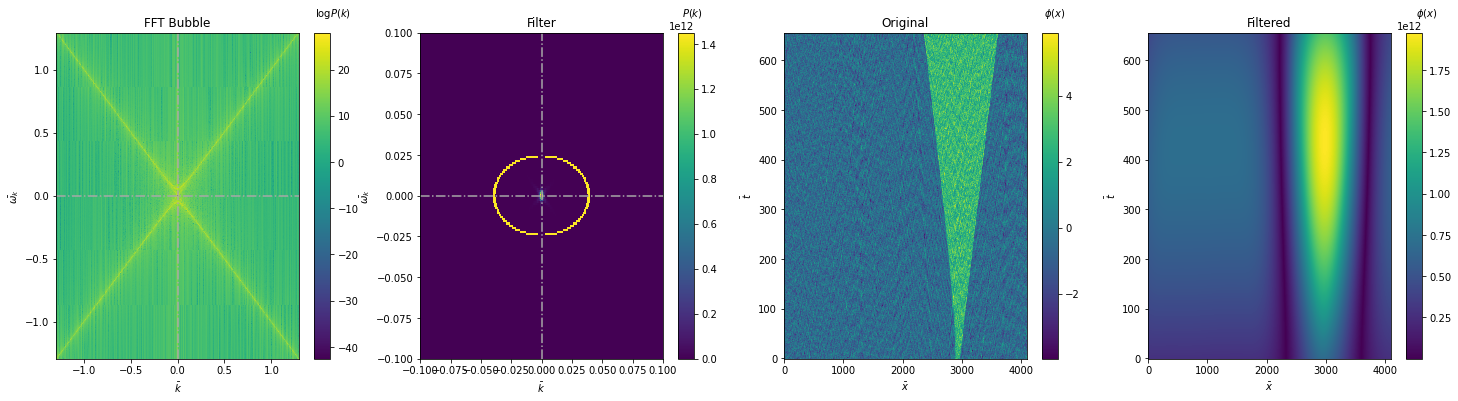

In [6]:
p1=0.4#0.4
p2=0.25#0.25
p3=0.1#0.18
step = 20

lamb = 6.
phi0 = 2*np.pi/7.

if True:
    list_window = []
    for sim in range(0, 50, step):
        if os.path.exists(bubbles_file(sim, phi0, lamb, lenLat, nLat)):
            bubble = np.load(bubbles_file(sim, phi0, lamb, lenLat, nLat))[0]
            bubble = bubble[time_at_fraction(bubble, 0.1, 4):time_at_fraction(bubble, 0.5, 4)]
            bubble = bubble-np.mean(bubble)
            bT, bN = bubble.shape

            extension = np.zeros(bubble.shape)
            extension2 = np.concatenate((extension, extension, extension), axis=1)
            # make rhombus
#            bubble = np.concatenate((extension2, np.concatenate((extension, bubble, extension), axis=1), np.concatenate((extension, bubble[::-1], extension), axis=1), extension2), axis=0)
            # extend by zero matrices
#            bubble = np.concatenate((extension2, np.concatenate((extension, bubble, extension), axis=1), extension2), axis=0)
            # extend by zero matrices only in time
            bubble = np.concatenate((extension, bubble, extension), axis=0)

            bT2, bN2 = bubble.shape
            bubblePS = np.abs(np.fft.fftshift(np.fft.fft2(bubble)))**2.
            kk = np.fft.fftshift(np.fft.fftfreq(bN2,d=dx))
            oo = np.fft.fftshift(np.fft.fftfreq(bT2,d=dtout))
            KK, OO = np.meshgrid(kk,oo)

            coords = ((KK/p1)**2 + (OO/p2)**2 <= p3**2)
            # filter from signal
            window = bubblePS*coords
            # point spread functionish
    #        window = gaussian_filter(1.*coords, sigma=5)
    #        cdss = np.meshgrid(np.asarray([i[0] for i in np.argwhere((-0.1<oo)&(oo<0.1))]), np.asarray([i[0] for i in np.argwhere((-0.1<kk)&(kk<0.1))]))
            list_window.append(window)#[cdss])

            filtered = np.sqrt(np.abs(np.fft.ifft2(np.fft.fftshift(np.fft.fft2(bubble))*window))**2.)[bT:2*bT, :]
            bubblePS = np.abs(np.fft.fftshift(np.fft.fft2(bubble)))**2.
            bubble = bubble[bT:2*bT, :]

            fig, ax = plt.subplots(1, 4, figsize=(25, 6))
        #    im = ax[0].imshow(bubblePS + (bubblePS*0.+np.amax(bubblePS))*(((p3-0.005)**2 <= (KK/p1)**2 + (OO/p2)**2) & ((KK/p1)**2 + (OO/p2)**2 <= p3**2)), aspect='auto', interpolation='none', origin='lower', extent=[kk[0],kk[-1],oo[0],oo[-1]])
            im = ax[0].imshow(np.log(bubblePS), aspect='auto', interpolation='none', origin='lower', extent=[kk[0],kk[-1],oo[0],oo[-1]])
            clb = plt.colorbar(im, ax = ax[0])
            clb.set_label(r'$\log P(k)$', labelpad=-25, y=1.08, rotation=0)

            im = ax[1].imshow(window + (window*0.+np.amax(window))*(((p3-0.005)**2 <= (KK/p1)**2 + (OO/p2)**2) & ((KK/p1)**2 + (OO/p2)**2 <= p3**2)), aspect='auto', interpolation='none', origin='lower', extent=[kk[0],kk[-1],oo[0],oo[-1]])
            clb = plt.colorbar(im, ax = ax[1])
            clb.set_label(r'$P(k)$', labelpad=-25, y=1.08, rotation=0)
            [ax[i].set_xlabel(r'$\bar{k}$') for i in range(len(ax)//2)]
            [ax[i].set_ylabel(r'$\bar{\omega_k}$') for i in range(len(ax)//2)]
            ax[1].set_xlim(-0.1,0.1)
            ax[1].set_ylim(-0.1,0.1)
            [ax[i].axvline(0, color='darkgray', ls='-.') for i in range(len(ax)//2)]
            [ax[i].axhline(0, color='darkgray', ls='-.') for i in range(len(ax)//2)]

            im1 = ax[2].imshow(bubble, aspect='auto', interpolation='none', origin='lower')
            clb = plt.colorbar(im1, ax = ax[2])
            clb.set_label(r'$\phi(x)$', labelpad=-25, y=1.08, rotation=0)
            im2 = ax[3].imshow(filtered, aspect='auto', interpolation='none', origin='lower')
            clb = plt.colorbar(im2, ax = ax[3])
            clb.set_label(r'$\phi(x)$', labelpad=-25, y=1.08, rotation=0)
            [ax[i].set_xlabel(r'$\bar{x}$') for i in range(len(ax)//2, len(ax))]
            [ax[i].set_ylabel(r'$\bar{t}$') for i in range(len(ax)//2, len(ax))]
            [ax[i].set_title(['FFT Bubble', 'Filter', 'Original', 'Filtered'][i]) for i in range(len(ax))]
            plt.show()

### Check Longevity of Oscillon 

In [7]:
def plot_2dsim(simulation, sim, bool):
    print(simulation.shape)
    fig, ax = plt.subplots(1, 1, figsize = (7, 5))
    if bool:
        im = ax.imshow(simulation, aspect='auto', interpolation='none', origin='lower', extent=[0, np.sqrt(4*nu)*len(simulation[0])*dx, 0, np.sqrt(4*nu)*len(simulation)*dtout])
    else:
        im = ax.imshow(simulation, aspect='auto', interpolation='none', origin='lower')
    clb = plt.colorbar(im, ax = ax)
    clb.set_label(r'$\phi(t, r)$', labelpad=-28, y=1.08, rotation=0)
    ax.set_title('Simulation '+str(sim))
    ax.set(xlabel = r'$\phi_0^{-1} \sqrt{V_0} r$', ylabel = r'$\phi_0^{-1} \sqrt{V_0} t$')
    multp = 2
    clb.set_ticks(np.arange(-10, 20)*np.pi/multp, update_ticks=True)
    clb.set_ticklabels(['0' if iii == 0 else r'$\pi$' if (iii/multp)==1. else r'$-\pi$' if (iii/multp)==-1. else str(int(iii/multp))+r'$\pi$' 
                        if (iii/multp).is_integer()>0 else str(-int(np.abs(iii)/multp))+r'$\pi$' if (iii/multp).is_integer()<0 else r'$\frac{\pi}{%s}$'%(multp) 
                        if iii==1. else r'$-\frac{\pi}{%s}$'%(multp) if iii==-1. else r'$\frac{%s\pi}{%s}$'%(iii, multp) if iii>1 
                        else r'$-\frac{%s\pi}{%s}$'%(np.abs(iii), multp) for iii in np.arange(-10, 20)], update_ticks=True)
    plt.show()
    return

def plot_all(precursorPS, window, precursor, filtered, limit):
    fig, ax = plt.subplots(1, 4, figsize=(25, 6))
    im = ax[0].imshow(np.log(precursorPS), aspect='auto', interpolation='none', origin='lower', extent=[kk[0],kk[-1],oo[0],oo[-1]])
    clb = plt.colorbar(im, ax = ax[0])
    clb.set_label(r'$\log P(k)$', labelpad=-25, y=1.08, rotation=0)

    im = ax[1].imshow(window + (window*0.+np.amax(window))*(((p3-0.005)**2 <= (KK/p1)**2 + (OO/p2)**2) & ((KK/p1)**2 + (OO/p2)**2 <= p3**2)), aspect='auto', interpolation='none', origin='lower', extent=[kk[0],kk[-1],oo[0],oo[-1]])
    clb = plt.colorbar(im, ax = ax[1])
    clb.set_label(r'$P(k)$', labelpad=-25, y=1.08, rotation=0)
    [ax[i].set_xlabel(r'$\bar{k}$') for i in range(len(ax)//2)]
    [ax[i].set_ylabel(r'$\bar{\omega_k}$') for i in range(len(ax)//2)]
    ax[1].set_xlim(-limit,limit)
    ax[1].set_ylim(-limit,limit)
    [ax[i].axvline(0, color='darkgray', ls='-.') for i in range(len(ax)//2)]
    [ax[i].axhline(0, color='darkgray', ls='-.') for i in range(len(ax)//2)]

    im1 = ax[2].imshow(precursor, aspect='auto', interpolation='none', origin='lower')
    clb = plt.colorbar(im1, ax = ax[2])
    clb.set_label(r'$\phi(x)$', labelpad=-25, y=1.08, rotation=0)
    im2 = ax[3].imshow(filtered, aspect='auto', interpolation='none', origin='lower')
    clb = plt.colorbar(im2, ax = ax[3])
    clb.set_label(r'$\phi(x)$', labelpad=-25, y=1.08, rotation=0)
    [ax[i].set_xlabel(r'$\bar{x}$') for i in range(len(ax)//2, len(ax))]
    [ax[i].set_ylabel(r'$\bar{t}$') for i in range(len(ax)//2, len(ax))]
    [ax[i].set_title(['FFT Bubble Precursor', 'Filter', 'Original', 'Filtered'][i]) for i in range(len(ax))]
    plt.show()
    return

def plot_shebang(precPS, window, prec, newPrec, limit=0.15):
    fig, ax = plt.subplots(1, 4, figsize=(25, 6))
    [ax[i].set_xlabel(r'$\bar{x}$') for i in range(len(ax)//2, len(ax))]
    [ax[i].set_ylabel(r'$\bar{t}$') for i in range(len(ax)//2, len(ax))]
    [ax[i].set_title(['FFT Bubble Precursor', 'Filter', 'Original', 'Filtered'][i]) for i in range(len(ax))]
    [ax[i].set_xlabel(r'$\bar{k}$') for i in range(len(ax)//2)]
    [ax[i].set_ylabel(r'$\bar{\omega_k}$') for i in range(len(ax)//2)]
    ax[1].set_xlim(-limit,limit)
    ax[1].set_ylim(-limit,limit)
    #[ax[i].axvline(0, color='darkgray', ls='-.') for i in range(len(ax)//2)]
    #[ax[i].axhline(0, color='darkgray', ls='-.') for i in range(len(ax)//2)]

    im = ax[0].imshow(np.log(precPS), aspect='auto', interpolation='none', origin='lower', extent=[kk[0],kk[-1],oo[0],oo[-1]])
    im = ax[1].imshow(window, aspect='auto', interpolation='none', origin='lower', extent=[kk[0],kk[-1],oo[0],oo[-1]])
    im1 = ax[2].imshow(prec, aspect='auto', interpolation='none', origin='lower')
    im2 = ax[3].imshow(newPrec, aspect='auto', interpolation='none', origin='lower')
    #clb = plt.colorbar(im, ax = ax); clb.set_label(r'$\phi(x)$', labelpad=-25, y=1.08, rotation=0)
    plt.show()
    return

(8077, 4096)


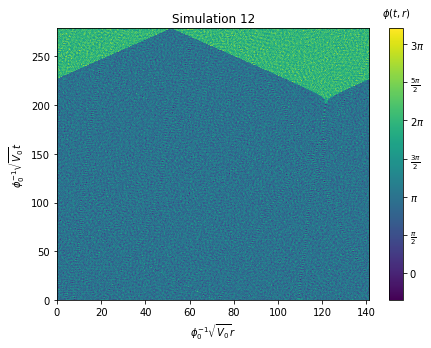

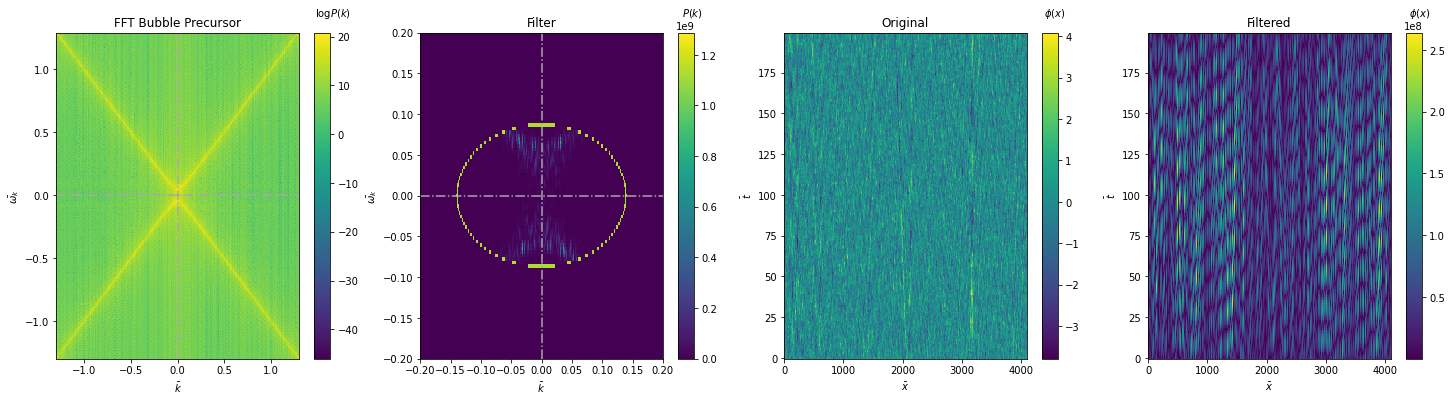

In [8]:
for sim in range(12, 13):
    if os.path.exists(bubbles_file(sim, phi0, lamb, lenLat, nLat)):
        simulation = np.load(bubbles_file(sim, phi0, lamb, lenLat, nLat))[0]
#        simulation = simulation[:, int(2*simulation.shape[1]/3):simulation.shape[1]]
        plot_2dsim(simulation, sim, True)
        
        precursor = simulation[:200]
        precursor = precursor-np.mean(precursor)
        bT, bN = precursor.shape

        extension = np.zeros(precursor.shape)
        extension2 = np.concatenate((extension, extension, extension), axis=1)
        # extend by zero matrices
        precursor = np.concatenate((extension2, np.concatenate((extension, precursor, extension), axis=1), extension2), axis=0)

        bT2, bN2 = precursor.shape
        precursorPS = np.abs(np.fft.fftshift(np.fft.fft2(precursor)))**2.
        kk = np.fft.fftshift(np.fft.fftfreq(bN2,d=dx))
        oo = np.fft.fftshift(np.fft.fftfreq(bT2,d=dtout))
        KK, OO = np.meshgrid(kk,oo)

        p1=0.4#0.4
        p2=0.25#0.25
        p3=0.35#0.18
        coords = ((KK/p1)**2 + (OO/p2)**2 <= p3**2)
        # filter from signal
        window = precursorPS*coords
        # point spread functionish
#        window = gaussian_filter(1.*coords, sigma=5)
    
        filtered = np.sqrt(np.abs(np.fft.ifft2(np.fft.fftshift(np.fft.fft2(precursor))*window))**2.)[bT:2*bT, bN:2*bN]
        precursorPS = np.abs(np.fft.fftshift(np.fft.fft2(precursor)))**2.
        precursor = precursor[bT:2*bT, bN:2*bN]
        
        plot_all(precursorPS, window, precursor, filtered, limit=0.2)

In [9]:
import os
import sys
module_path = sys.path.append('/home/dpirvu/.local/lib/python3.8/site-packages/')
module_path = sys.path.append('/home/dpirvu/.local/bin/')
for i in sys.path:
    i = i.replace("8", "7")
    if i not in sys.path:
        sys.path.append(i)
        print(i)

from celluloid import Camera

/cm/shared/apps/conda-environments/python37/lib/python37.zip
/cm/shared/apps/conda-environments/python37/lib/python3.7
/cm/shared/apps/conda-environments/python37/lib/python3.7/lib-dynload
/cm/shared/apps/conda-environments/python37/lib/python3.7/site-packages
/cm/shared/apps/conda-environments/python37/lib/python3.7/site-packages/IPython/extensions
/home/dpirvu/.local/lib/python3.7/site-packages/


2192
0 200
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100


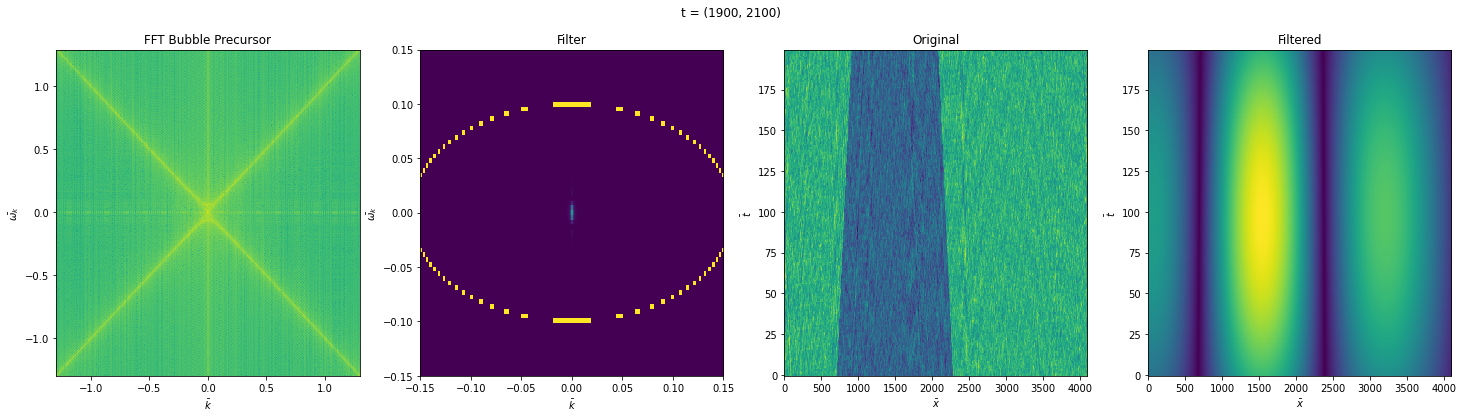

In [10]:
sim = 12
simulation = np.load(bubbles_file(sim, phi0, lamb, lenLat, nLat))[0]
simulation = simulation[-int(simulation.shape[0]/3):-500]
print(len(simulation))
limit = 0.15
p1=0.4#0.4
p2=0.25#0.25
p3=0.4#0.18

fig, ax = plt.subplots(1, 4, figsize=(25, 6))
camera = Camera(fig)
[ax[i].set_xlabel(r'$\bar{x}$') for i in range(len(ax)//2, len(ax))]
[ax[i].set_ylabel(r'$\bar{t}$') for i in range(len(ax)//2, len(ax))]
[ax[i].set_title(['FFT Bubble Precursor', 'Filter', 'Original', 'Filtered'][i]) for i in range(len(ax))]
[ax[i].set_xlabel(r'$\bar{k}$') for i in range(len(ax)//2)]
[ax[i].set_ylabel(r'$\bar{\omega_k}$') for i in range(len(ax)//2)]
ax[1].set_xlim(-limit,limit)
ax[1].set_ylim(-limit,limit)
#[ax[i].axvline(0, color='darkgray', ls='-.') for i in range(len(ax)//2)]
#[ax[i].axhline(0, color='darkgray', ls='-.') for i in range(len(ax)//2)]

for amin, amax in zip(np.arange(0, len(simulation), 100), np.arange(200, len(simulation), 100)):
    print(amin, amax)
    precursor = simulation[amin:amax]
    precursor = precursor-np.mean(precursor)
    bT, bN = precursor.shape

    extension = np.zeros(precursor.shape)
    extension2 = np.concatenate((extension, extension, extension), axis=1)
    # extend by zero matrices
    precursor = np.concatenate((extension2, np.concatenate((extension, precursor, extension), axis=1), extension2), axis=0)

    precursorPS = np.abs(np.fft.fftshift(np.fft.fft2(precursor)))**2.
    kk = np.fft.fftshift(np.fft.fftfreq(precursor.shape[1],d=dx))
    oo = np.fft.fftshift(np.fft.fftfreq(precursor.shape[0],d=dtout))
    KK, OO = np.meshgrid(kk,oo)
    coords = ((KK/p1)**2 + (OO/p2)**2 <= p3**2)
    
    # filter from signal
    window = precursorPS*coords
    # point spread functionish
#    window = gaussian_filter(1.*coords, sigma=5)
    
    filtered = np.sqrt(np.abs(np.fft.ifft2(np.fft.fftshift(np.fft.fft2(precursor))*window))**2.)[bT:2*bT, bN:2*bN]
    precursor = precursor[bT:2*bT, bN:2*bN]

    im = ax[0].imshow(np.log(precursorPS), aspect='auto', interpolation='none', origin='lower', extent=[kk[0],kk[-1],oo[0],oo[-1]])
    im = ax[1].imshow(window + (window*0.+np.amax(window))*(((p3-0.005)**2 <= (KK/p1)**2 + (OO/p2)**2) & ((KK/p1)**2 + (OO/p2)**2 <= p3**2)), aspect='auto', interpolation='none', origin='lower', extent=[kk[0],kk[-1],oo[0],oo[-1]])
    im1 = ax[2].imshow(precursor, aspect='auto', interpolation='none', origin='lower')
    im2 = ax[3].imshow(filtered, aspect='auto', interpolation='none', origin='lower')
#    clb = plt.colorbar(im, ax = ax); clb.set_label(r'$\phi(x)$', labelpad=-25, y=1.08, rotation=0)
    fig.suptitle(f't = {amin, amax}')
    camera.snap()

animation = camera.animate(interval = 400);
animation.save('/home/dpirvu/average_bubble/oscillon/oscillon.gif', writer = 'imagemagick')

### What does bubble inside look like 

In [15]:
def extend_precursor(precursor):
    precursor = precursor-np.mean(precursor)
    extension = np.zeros(precursor.shape)
    extension2 = np.concatenate((extension, extension, extension), axis=1)
    # extend by zero matrices
    precursor = np.concatenate((extension2, np.concatenate((extension, precursor, extension), axis=1), extension2), axis=0)
    return precursor

def extend_window_and_precursor(precursor, window):
    precursor = precursor-np.mean(precursor)
    extension = np.zeros(precursor.shape)
    extension2 = np.concatenate((extension, extension, extension), axis=1)
    precursor = np.concatenate((extension2, np.concatenate((extension, precursor, extension), axis=1), extension2), axis=0)
    bT, bN = precursor.shape
    wT, wN = window.shape

    extension1 = np.zeros((wT, int(bN-wN)//2))
    extension2 = np.zeros((int(bT-wT)//2, bN))
    newwindow = np.concatenate((extension2, np.concatenate((extension1, window, extension1), axis=1), extension2), axis=0)
    return newwindow, precursor

def filtered(precursor, window):
    bT, bN = precursor.shape
    precursor = extend_precursor(precursor)
    return np.sqrt(np.abs(np.fft.ifft2(np.fft.fftshift(np.fft.fft2(precursor))*window))**2.)[bT:2*bT, :]#bN:2*bN]

def odd_filtered(precursor, window):
    bT, bN = precursor.shape
    window, precursor = extend_window_and_precursor(precursor, window)
    return np.sqrt(np.abs(np.fft.ifft2(np.fft.fftshift(np.fft.fft2(precursor))*window))**2.)[bT:2*bT, :]#bN:2*bN]

def make_window(precursor, dx, dtout, p1, p2, p3, p4, p5, p6, bool):
    precursor = extend_precursor(precursor)
    precursorPS = np.abs(np.fft.fftshift(np.fft.fft2(precursor)))**2.
    kk = np.fft.fftshift(np.fft.fftfreq(precursor.shape[1],d=dx))
    oo = np.fft.fftshift(np.fft.fftfreq(precursor.shape[0],d=dtout))
    KK, OO = np.meshgrid(kk,oo)
    # for ellipse
#    coords1 = ((KK/p1)**2 + (OO/p2)**2 <= p3**2)
#    coords2 = ((KK/p1)**2 + (OO/p2)**2 <= (p3-0.005)**2)
    # for hyperbola below radiative modes
#    coords1 = ( - (KK/p1)**2 + (OO/p2)**2 <= p3**2)
#    coords2 = ( - (KK/p1)**2 + (OO/p2)**2 <= (p3-0.005)**2)
    # hyperbola above and below radiative modes
    coords1 = ( - (KK/p1)**2 + (OO/p2)**2 <= p3**2) ^ ( - (KK/p4)**2 + (OO/p5)**2 >= p6**2)
    coords2 = ( - (KK/p1)**2 + (OO/p2)**2 <= (p3-0.005)**2) & ( - (KK/p4)**2 + (OO/p5)**2 >= (p6-0.005)**2)
    if bool: # filter from signal
        window = precursorPS*coords1
    else: # point spread functionish
        window = gaussian_filter(1.*coords1, sigma=5)

    limt = 0.2
    fig, ax = plt.subplots(1, 1, figsize=(9, 6))
    im = ax.imshow(window + (window*0.-np.amax(window))*(coords1&coords2), aspect='auto', interpolation='none', origin='lower', cmap='viridis', extent=[kk[0],kk[-1],oo[0],oo[-1]])
    clb = plt.colorbar(im, ax = ax); clb.set_label(r'$P(k)$', labelpad=-25, y=1.08, rotation=0)
    ax.set_xlabel(r'$\bar{k}$'); ax.set_ylabel(r'$\bar{\omega_k}$'); ax.set_xlim(-limt,limt); ax.set_ylim(-limt,limt)
    ax.axvline(0, color='darkgray', ls='-.'); ax.axhline(0, color='darkgray', ls='-.')
    return window, precursorPS

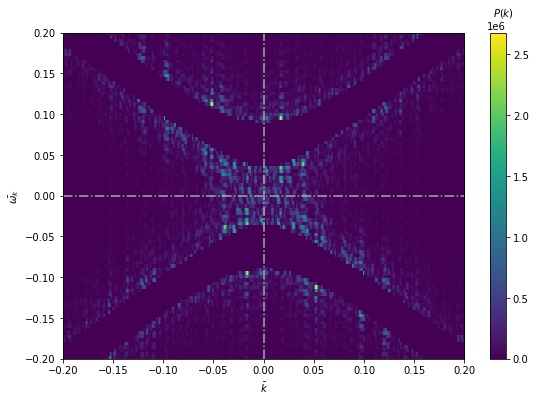

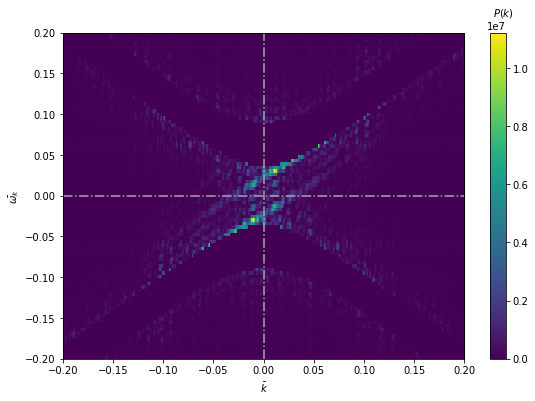

In [12]:
sim = 12
simulation = np.load(bubbles_file(sim, phi0, lamb, lenLat, nLat))[0]
#plot_2dsim(simulation, sim, False)

precs, precsPS, filters = [], [], []
for precursor in [simulation[-1000:-800, 3100:-200], simulation[-200:, 3100:-200]]:
#    plot_2dsim(precursor, sim, False)
#    window, postprecursorPS = make_window(precursor, dx, dtout, p1=0.4, p2=0.25, p3=0.5, bool=True) # for ellipse
#    window, postprecursorPS = make_window(precursor, dx, dtout, p1=0.5, p2=0.5, p3=0.03, bool=True) # for hyperbola
    window, postprecursorPS = make_window(precursor, dx, dtout, p1=0.5, p2=0.45, p3=0.08, p4=0.4, p5=0.45, p6=0.2, bool=True) # for hyperbola

    precs.append(np.asarray(precursor))
    filters.append(np.asarray(window))
    precsPS.append(np.asarray(postprecursorPS))

(600, 2388) (200, 796) (600, 2388)


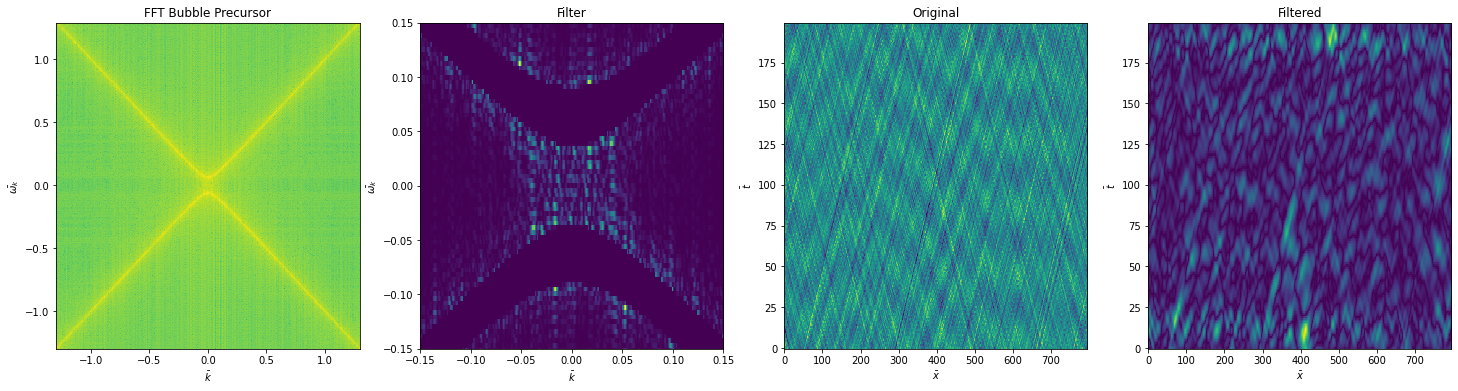

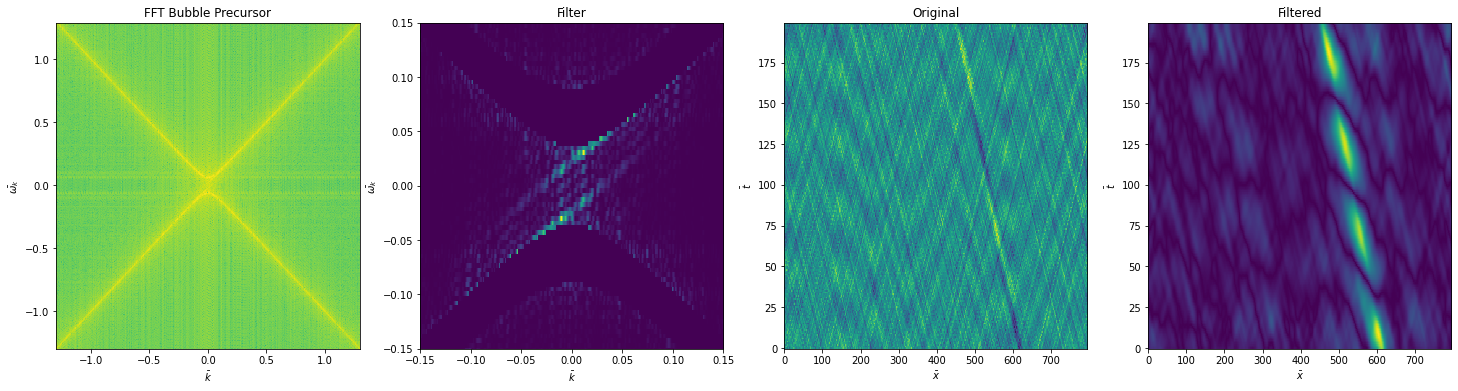

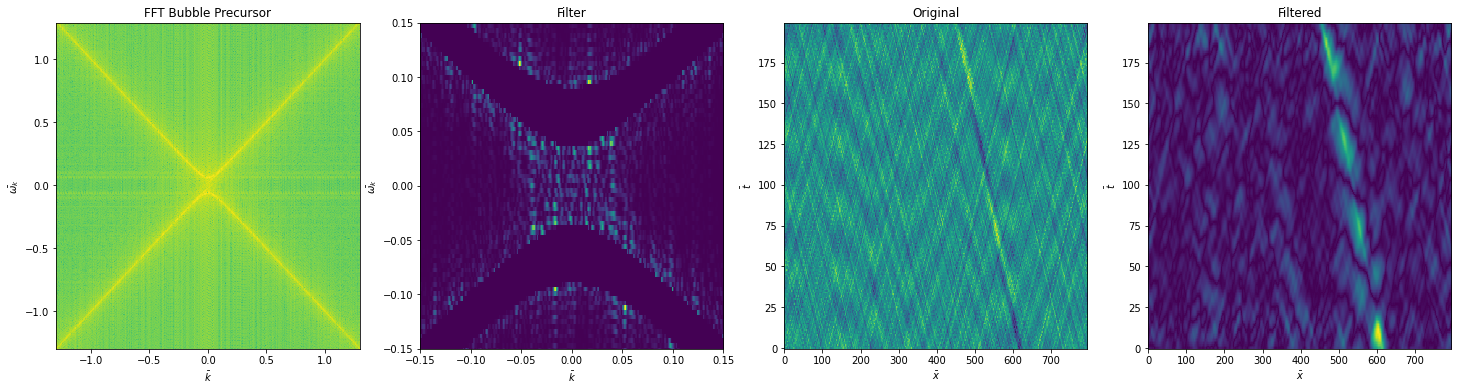

In [13]:
window, prec, precPS = filters[:1:][0], precs[:1:][0], precsPS[:1:][0]
print(np.shape(window), np.shape(prec), np.shape(precPS))

newPrec = filtered(prec, window)
plot_shebang(precPS, window, prec, newPrec, limit=0.15)

window, prec, precPS = filters[1:2:][0], precs[1:2:][0], precsPS[1:2:][0]
newPrec = filtered(prec, window)
plot_shebang(precPS, window, prec, newPrec, limit=0.15)

window, prec, precPS = filters[:1:][0], precs[1:2:][0], precsPS[1:2:][0]
newPrec = filtered(prec, window)
plot_shebang(precPS, window, prec, newPrec, limit=0.15)

### Smoothen Bubble with Oscillon Filter

In [16]:
smooths0 = odd_filtered(simulation, filters[0]) # takes set filter and applies it to random image independent of size
plot_2dsim(smooths0, sim, False)

smoothsl = odd_filtered(simulation[-800:,:], filters[0]) # takes set filter and applies it to random image independent of size
plot_2dsim(smoothsl, sim, False)

smoothsl = odd_filtered(simulation[:,-1200:], filters[0]) # takes set filter and applies it to random image independent of size
plot_2dsim(smoothsl, sim, False)

smoothsl = odd_filtered(simulation[-800:,-1200:], filters[0]) # takes set filter and applies it to random image independent of size
plot_2dsim(smoothsl, sim, False)

ValueError: operands could not be broadcast together with shapes (24231,12288) (24230,12288) 

### Mass Spread over Ensemble 

(3, 600, 2388)


IndexError: list index out of range

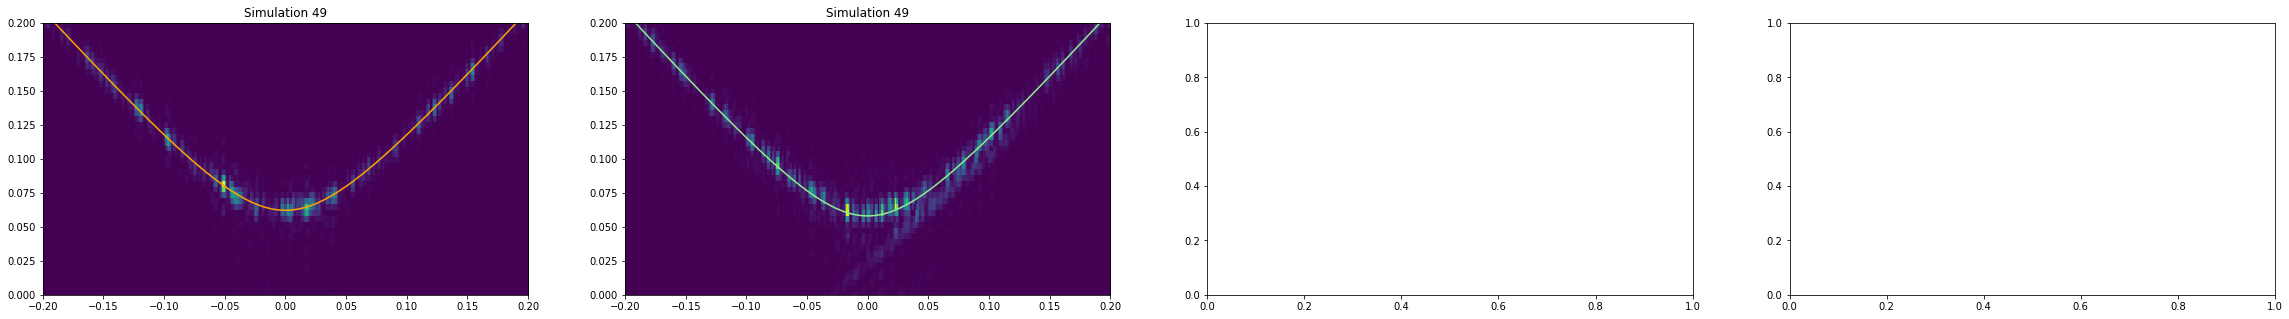

In [34]:
limit = 0.2
popt = []
cols = ['orange', 'lightgreen']

# fit to k^2  + m^2= o^2
def omega(k, a, m):
    return a*k + m**2

print(np.shape(precsPS))
precsPS.append(np.mean(precsPS, axis=0))

fig, ax = plt.subplots(1, len(precsPS), figsize = (10*len(precsPS), 5))
for jj in range(len(precsPS)):
    kk = np.fft.fftshift(np.fft.fftfreq(precsPS[jj].shape[1],d=dx))
    oo = np.fft.fftshift(np.fft.fftfreq(precsPS[jj].shape[0],d=dtout))
    KK, OO = np.meshgrid(kk,oo)
    coords = ((KK/p1)**2 + (OO/p2)**2 <= p3**2)

    # pairs (\omega_k, k)
    if jj < len(precsPS)-1:
        maxVal = np.mean(precsPS[jj]) + 5*np.std(precsPS[jj])
        osccoords = np.argwhere(precsPS[jj]>maxVal)
        popt.append(sco.curve_fit(omega, kk[osccoords[:,1]]**2., oo[osccoords[:,0]]**2.)[0])
        ax[jj].plot(kk, np.sqrt(omega(kk**2,*popt[-1])), color=cols[len(popt)-1], label='fit '+str(len(popt))+': m=%5.5f'%popt[-1][-1])
    else:
        [ax[jj].plot(kk, np.sqrt(omega(kk**2,*popt[ii])), color=cols[ii], label='fit '+str(ii+1)) for ii in range(len(popt))]

    im = ax[jj].imshow(precsPS[jj], aspect='auto', interpolation='none', origin='lower', extent=[kk[0],kk[-1],oo[0],oo[-1]])
#    clb = plt.colorbar(im, ax = ax[jj]); clb.set_label(r'$\phi(t, r)$', labelpad=-28, y=1.08, rotation=0)
    ax[jj].set_xlim(-limit, limit)
    ax[jj].set_ylim(0, limit)
    ax[jj].set_title('Simulation '+str(sim))
[ax[i].set_xlabel(r'$\bar{k}$') for i in range(len(ax))]
[ax[i].set_ylabel(r'$\bar{\omega_k}$') for i in range(len(ax))]
#[ax[i].axvline(0, color='darkgray', ls='-.') for i in range(len(ax))]
#[ax[i].axhline(0, color='darkgray', ls='-.') for i in range(len(ax))]
[ax[i].legend() for i in range(len(ax))]

In [114]:
def get_mass_distrib(data_lists, bindiv, massthr, cutmodes, bool1=True, bool2=True):
    #cols = cycle(('b', 'orange', 'green', 'red', 'yellow', 'k', 'm', 'c'))
    oolist, kklist, kklistold = [], [], []
    for kk2, oo2, popt in data_lists: 
        elem = np.sort(kk2)[cutmodes]#len(kk2)-2]
        oo2 = oo2[kk2 <= elem]
        kk2 = kk2[kk2 <= elem]

#        oo2 = oo2[kk2 <= 0.00005]
#        kk2 = kk2[kk2 <= 0.00005]
        oolist.append(oo2)
        kklist.append(kk2)
    oolist = np.asarray([item for sublist in oolist for item in sublist])
    kklist = np.asarray([item for sublist in kklist for item in sublist])
    #kklistold = np.asarray([item for sublist in kklistold for item in sublist])
    #kklistold = kklistold[kklistold==0.]
    print('mass from fit', np.mean(data_lists[-1][-1]))

    if bool1:
        fig, ax = plt.subplots(1, 1, figsize=(10,5))
        #plt.style.use('seaborn-whitegrid') # nice and clean grid
        plt.hist(oolist, bins=len(oolist)//bindiv, facecolor = '#2ab0ff', edgecolor='#169acf')
        plt.axvline(massthr, color='darkgray', ls=':')
        plt.title('Mass Distribution') 
        plt.xlabel('Bins') 
        plt.ylabel('Values') 
        plt.show()

    # discard bubble modes setting threshold to 0.001
    kklist = kklist[oolist > massthr]
    oolist = oolist[oolist > massthr]

    hist, binedges = np.histogram(oolist, bins=len(oolist)//bindiv)
    bincenters = np.mean(np.vstack([binedges[0:-1],binedges[1:]]), axis=0)
    xData, yData = binedges[:-1], hist
    yData = yData / np.sum(yData)

    # Initial guess of the parameters (you must find them some way!)
    gamma_guess = np.std(yData)
    x0_guess = np.mean(xData)
    sigma_guess = np.std(yData)
    pguessL = [x0_guess, gamma_guess, 1]
    pguessG = [x0_guess, sigma_guess, 1]

    # Fit the data
    poptG, pcovG = sco.curve_fit(gaussian, xData, yData, p0 = pguessG)
    poptL, pcovL = sco.curve_fit(lorentzian, xData, yData, p0 = pguessL)

    sigma_abG = np.sqrt(np.diagonal(pcovG))
    sigma_abL = np.sqrt(np.diagonal(pcovL))

    from uncertainties import ufloat # an easy way to properly format parameter errors
    x0G, sigma = ufloat(poptG[0], sigma_abG[0]), ufloat(poptG[1], sigma_abG[1])
    text_resG = 'Best Gaussian fit parameters:\nx0 = {},\nsigma = {}'.format(x0G, sigma); print(text_resG)
    x0L, gamma = ufloat(poptL[0], sigma_abL[0]), ufloat(poptL[1], sigma_abL[1])
    text_resL = 'Best Lorentzian fit parameters:\nx0 = {},\ngamma = {}'.format(x0L, gamma); print(text_resL)

    if bool2:
        fig, ax = plt.subplots(1, 1, figsize=(10,5))
        plt.scatter(xData, yData, facecolor = 'silver', edgecolor = 'k', s = 20, alpha = 1)
        plt.plot(xData, gaussian(xData, *poptG), color='orange')
        plt.plot(xData, lorentzian(xData, *poptL), color='g')

        bound_upperG, bound_lowerG = gaussian(xData, *(poptG + sigma_abG)), gaussian(xData, *(poptG - sigma_abG))
        bound_upperL, bound_lowerL = lorentzian(xData, *(poptL + sigma_abL)), lorentzian(xData, *(poptL - sigma_abL))

        # plotting the confidence intervals
        plt.fill_between(xData, bound_lowerG, bound_upperG, alpha = 0.15, color='orange')
        plt.fill_between(xData, bound_lowerL, bound_upperL, alpha = 0.15, color='g')
        plt.show()
    return

In [115]:
# fit to k^2  + m^2= o^2
def omega(k, a, m):
    return a*k + m
# fit to Lorentzian distrib
def lorentzian(x, x0, gamma, norm):
    return norm*gamma**2/((x-x0)**2+gamma**2)
def gaussian(x, x0, sigma, norm):
    return norm*np.exp(-0.5*(x-x0)**2/sigma**2)

#lamb = 6.
#data_lists = []

lamb = 1.5
data_lists = []
for phi0 in [2*np.pi/7.]:#, 2*np.pi/7.5]:
    data_lists.append([])
    for sim in range(50):
        file = '/gpfs/dpirvu/sims/free_x4096_phi00.8976_lambda1.5000_sim'+str(sim)+'_fields.dat'
#        if os.path.exists(bubbles_file(sim, phi0, lamb, lenLat, nLat)):
        if os.path.exists(file):
#            simulation = np.load(bubbles_file(sim, phi0, lamb, lenLat, nLat))[0]
            simulation = np.genfromtxt(file)
            simulation = np.reshape(simulation, (len(simulation)//nLat, nLat))
#            simulation = simulation[:time_at_fraction(simulation, 0.02, right_phi_at_V_max(lamb).x)]
            simulation = simulation - np.mean(simulation)
            bT, bN = simulation.shape
#            plot_2dsim(simulation, sim, False)

            bubble = np.abs(np.fft.fftshift(np.fft.fft2(simulation)))**2.
            kk = np.fft.fftshift(np.fft.fftfreq(bN,d=dx))
            oo = np.fft.fftshift(np.fft.fftfreq(bT,d=dtout))
            KK, OO = np.meshgrid(kk, oo)

            maxVal = np.mean(bubble) + np.std(bubble)
            bub_coords = np.argwhere(bubble > maxVal)
            kk2, oo2 = (kk[bub_coords[:,1]])**2., (oo[bub_coords[:,0]])**2.
            popt1, pcov1 = sco.curve_fit(omega, kk2, oo2)
            data_lists[-1].append(np.asarray([kk2, oo2, popt1]))
            
            del KK, OO, kk, oo, kk2, oo2, bubble

/cm/shared/apps/conda-environments/python38/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [116]:
m2 = 4*nu*(-1+lamb**2); print(m2)

0.01


mass from fit 0.4104742667963221


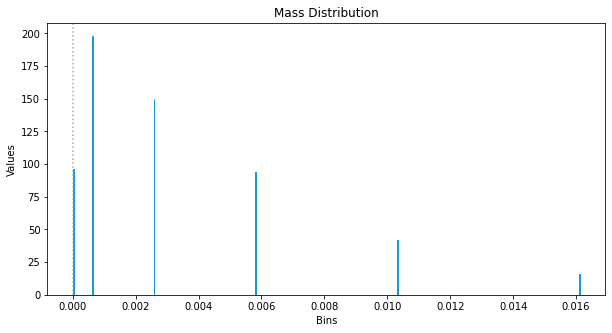

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 800.

In [121]:
get_mass_distrib(data_lists[0], bindiv=1, massthr=0., cutmodes=0, bool1=True, bool2=True)

Best Gaussian fit parameters:
x0 = 0.003082+/-0.000017,
sigma = -0.000605+/-0.000018
Best Lorentzian fit parameters:
x0 = 0.003127+/-0.000017,
gamma = -0.000609+/-0.000026


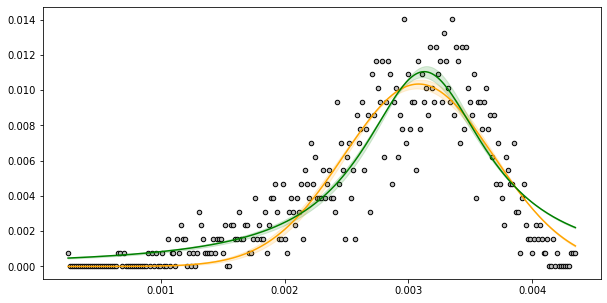

In [22]:
#get_mass_distrib(data_lists[0], bindiv=10, bool1=False, bool2=True)

### Three ways to get bubble interior 

In [23]:
def method1(simulation):
    maxx, _ = time_at_max_fraction(simulation, right_phi_at_V_max(lamb).x)
    angle = int(simulation.shape[1]/2.-maxx)
    simulation = np.asarray([np.roll(slice, angle) for slice in simulation])
    # use ndimage to mask bubble exterior
    C = simulation > 4. # set manually
#    SC = ndi.morphology.binary_closing(C, iterations=5, structure=np.ones((3,3)))
    SC = ndi.morphology.binary_opening(C, iterations=10, structure=np.ones((3,3)))
    simulation[~SC] = 0
    simulation[SC] = simulation[SC]-np.mean(simulation[SC]) # i.e. remove zero-frequency
    return simulation

def method2(simulation, lamb):
    # cut square inside bubble
    maxx, fraction = time_at_max_fraction(simulation, right_phi_at_V_max(lamb).x)
    optt = time_at_fraction(simulation, 0.4, right_phi_at_V_max(lamb).x)
    angle = int(simulation.shape[1]/2.-maxx)
    simulation = np.asarray([np.roll(slice, angle) for slice in simulation])
    inflim, suplim = simulation.shape[1]//2-500, simulation.shape[1]//2+500
    simulation = simulation[optt:, inflim:suplim]
    return simulation - np.mean(simulation)

def method3(simulation):
    # manually fourier transform
    return

In [24]:
#for lamb, phi0List in zip([1.5, 6], [[2*np.pi/4., 2*np.pi/4.5], [2*np.pi/7., 2*np.pi/7.]]):
#    for phi0 in phi0List:

#lamb = 6.
#phi0 = 2*np.pi/7.

lamb = 1.5
phi0 = 2*np.pi/7.

data_lists = []
for sim in range(50):
    if os.path.exists(bubbles_file(sim, phi0, lamb, lenLat, nLat)):
        bubble = np.load(bubbles_file(sim, phi0, lamb, lenLat, nLat))[0]
        bT, bN = bubble.shape
                
        bubble = method1(bubble)
#        bubble = method2(bubble, lamb)
        if any(i == 0 for i in bubble.shape): continue
#        plot_2dsim(bubble, sim, False)

        bubble = np.concatenate((np.zeros(bubble.shape), bubble, np.zeros(bubble.shape)), axis=0)
        bubble = np.abs(np.fft.fftshift(np.fft.fft2(bubble)))**2.
        kk = np.fft.fftshift(np.fft.fftfreq(bN,d=dx))
        oo = np.fft.fftshift(np.fft.fftfreq(bT,d=dtout))
        KK, OO = np.meshgrid(kk, oo)
#        fig, ax = plt.subplots(1,1,figsize=(6,5))
#        im = ax.imshow(bubble, aspect='auto', interpolation='none', origin='lower', extent=[kk[0],kk[-1],oo[0],oo[-1]])
#        clb = plt.colorbar(im, ax = ax); plt.show()

        maxVal = np.mean(bubble) + np.std(bubble)
        bub_coords = np.argwhere(bubble > maxVal)
        kk2, oo2 = (kk[bub_coords[:,1]])**2., (oo[bub_coords[:,0]])**2.
        popt1, pcov1 = sco.curve_fit(omega, kk2, oo2)
        data_lists.append(np.asarray([kk2, oo2, popt1]))

IndexError: index 30375 is out of bounds for axis 0 with size 30375

In [ ]:
#cols = cycle(('b', 'orange', 'green', 'red', 'yellow', 'k', 'm', 'c'))
oolist, kklist = [], []
for kk2, oo2, popt in data_lists:
    elem = np.sort(kk2)[2]#len(kk2)-2]
    oo2 = oo2[kk2 <= elem]
    kk2 = kk2[kk2 <= elem]
    oolist.append(oo2)
    kklist.append(kk2)
oolist = np.asarray([item for sublist in oolist for item in sublist])
kklist = np.asarray([item for sublist in kklist for item in sublist])
#kklistold = np.asarray([item for sublist in kklistold for item in sublist])
#kklistold = kklistold[kklistold==0.]

fig, ax = plt.subplots(1, 1, figsize=(10,5))
#plt.style.use('seaborn-whitegrid') # nice and clean grid
plt.hist(oolist, bins=len(oolist)//100, facecolor = '#2ab0ff', edgecolor='#169acf')
plt.title('Mass Distribution') 
plt.xlabel('Bins') 
plt.ylabel('Values') 
plt.show()

# discard bubble modes setting threshold to 0.001
kklist = kklist[oolist > 0.0001]
oolist = oolist[oolist > 0.0001]

hist, binedges = np.histogram(oolist, bins=len(oolist)//100)
bincenters = np.mean(np.vstack([binedges[0:-1],binedges[1:]]), axis=0)
xData, yData = bincenters, hist
yData = yData / np.sum(yData)

# Initial guess of the parameters (you must find them some way!)
gamma_guess = np.std(yData)
x0_guess = np.mean(xData)
sigma_guess = np.std(yData)
pguessL = [x0_guess, gamma_guess, 1]
pguessG = [x0_guess, sigma_guess, 1]

# Fit the data
poptG, pcovG = sco.curve_fit(gaussian, xData, yData, p0 = pguessG)
poptL, pcovL = sco.curve_fit(lorentzian, xData, yData, p0 = pguessL)

sigma_abG = np.sqrt(np.diagonal(pcovG))
sigma_abL = np.sqrt(np.diagonal(pcovL))

from uncertainties import ufloat # an easy way to properly format parameter errors
x0G, sigma = ufloat(poptG[0], sigma_abG[0]), ufloat(poptG[1], sigma_abG[1])
text_resG = 'Best Gaussian fit parameters:\nx0 = {},\nsigma = {}'.format(x0G, sigma); print(text_resG)
x0L, gamma = ufloat(poptL[0], sigma_abL[0]), ufloat(poptL[1], sigma_abL[1])
text_resL = 'Best Lorentzian fit parameters:\nx0 = {},\ngamma = {}'.format(x0L, gamma); print(text_resL)

fig, ax = plt.subplots(1, 1, figsize=(10,5))
plt.scatter(xData, yData, facecolor = 'silver', edgecolor = 'k', s = 20, alpha = 1)
plt.plot(xData, gaussian(xData, *poptG), color='orange')
plt.plot(xData, lorentzian(xData, *poptL), color='g')

bound_upperG, bound_lowerG = gaussian(xData, *(poptG + sigma_abG)), gaussian(xData, *(poptG - sigma_abG))
bound_upperL, bound_lowerL = lorentzian(xData, *(poptL + sigma_abL)), lorentzian(xData, *(poptL - sigma_abL))

# plotting the confidence intervals
plt.fill_between(xData, bound_lowerG, bound_upperG, alpha = 0.15, color='orange')
plt.fill_between(xData, bound_lowerL, bound_upperL, alpha = 0.15, color='g')
plt.show()